# Separable optimizers

Separable optimizers (*not a common term*) solve ... separable optimization tasks:
$$\mathcal{L}(\theta, \psi) = \frac{1}{N} \sum^N_{i = 1} L(\theta, \psi_i) \to \min$$
where:
- $\theta$ --- "shared" parameters;
- $\psi_i$ --- "separable" (or individual) parameters;

via stochastic optimization with estimates of gradients computed by taking a subset across $i$. For $\theta$ the estimates are classical batch estimates, for $\psi$, however, the estimates are either the proper gradient or zeros:
$$G^i_\psi = \begin{cases} \nabla L(\theta, \psi_i), \text{ if } i \in \text{batch};\\ 0, \text{ otherwise}. \end{cases}$$

It is easy to see, that such estimates are unbiased estimates of gradients, thus, the task can be reduced to a stochastic gradient optimization with **sparse** gradient estimates w.r.t. separable parameters.

`crayopt.gradient.separable` provides adaptation of conventional stochastic optimizers for efficiently handling **sparse** gradient estimates.

In [1]:
import jax
import jax.numpy as jnp

import crayopt

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

rng = jax.random.PRNGKey(112233)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Toy task

We would like to fit multiple linear regressions $f(x) = w x + b$ with shared $w$ and separable $b$ using MSE loss.

In [2]:
@jax.jit
def f(x, w, b):
    return w[None, None] * x + b[:, None]

@jax.jit
def loss(x, y, w, b):
    p = f(x, w, b)
    return jnp.mean(jnp.square(p - y))

d_loss_d_parameters = jax.jit(jax.grad(loss, argnums=(2, 3)))

In [3]:
n_regressions = 7
n_observations = 2
noise_std = 0.1
batch_size = 3

rng, key_data, key_eps, key_w, key_b = jax.random.split(rng, num=5)

data = jax.random.uniform(key_data, shape=(n_regressions, n_observations), minval=-1, maxval=1)
w_true = jax.random.normal(key_w, shape=())
b_true = jax.random.normal(key_b, shape=(n_regressions, ))

labels = f(data, w_true, b_true) + noise_std * jax.random.normal(key_eps, shape=(n_regressions, n_observations))

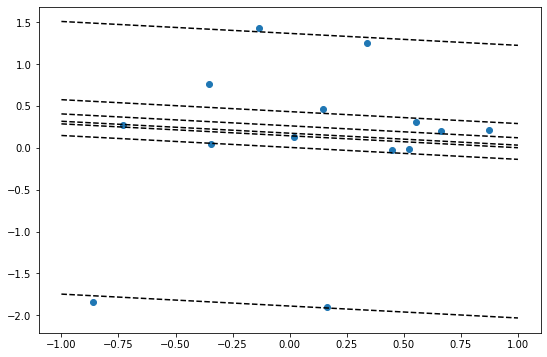

In [4]:
x_grid = jnp.broadcast_to(jnp.linspace(-1, 1, num=3)[None, :], shape=(n_regressions, 3))
f_grid = f(x_grid, w_true, b_true)

plt.figure(figsize=(9, 6))
plt.plot(x_grid.T, f_grid.T, color='black', linestyle='--')
plt.scatter(data.ravel(), labels.ravel())
plt.show()

In [5]:
rng, key_w, key_b = jax.random.split(rng, num=3)

initial_w = jax.random.normal(key_w, shape=())
initial_b = jax.random.normal(key_b, shape=(n_regressions, ))

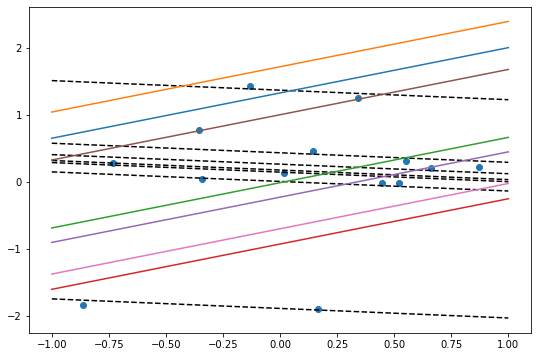

In [6]:
x_grid = jnp.broadcast_to(jnp.linspace(-1, 1, num=3)[None, :], shape=(n_regressions, 3))
f_grid = f(x_grid, w_true, b_true)
p_grid = f(x_grid, initial_w, initial_b)

plt.figure(figsize=(9, 6))
plt.plot(x_grid.T, f_grid.T, color='black', linestyle='--')
plt.plot(x_grid.T, p_grid.T)
plt.scatter(data.ravel(), labels.ravel())
plt.show()

In [7]:
optimizer = crayopt.separable.adam(learning_rate=1e-2)

### a small difference from conventional optimizer, separable ones accept shared and separable parameters as
### separate arguments
initial_state = optimizer.initial_state(initial_w, initial_b)

Separable optimizers try to perform lazy updates. For example, if a parameters was not selected for a batch for $n$ steps, then momentum $v$ can be efficiently recomputed for all $n$ steps at once:

$$v_n = \rho \cdot v_{n - 1} + (1 - \rho) \cdot 0 = \rho \cdot (\rho \cdot v_{n - 2} + (1 - \rho) \cdot 0) + (1 - \rho) \cdot 0 = \rho^n \cdot v_0$$

Separable optimizers perform such updates only when a parameter was selected into the current batch. **Of course, one has to update the selected separable parameters before computing the gradient.** The method `advance` performs these updates:

```python
batch_index = jnp.array([1, 2, 3, 5, 8]) ### better to sample it randomly
### advance method applies the neccessary updates to `batch_index`
separable, state = optimizer.advance(batch_index, separable, state)
### selecting the subset
separable_batch = crayopt.utils.tree.select(separable)[batch_index]
gradient = d_loss_d_params(shared, separable_batch)
...
```

In [8]:
@jax.jit
def step(index, shared, separable, state):
    separable, state = optimizer.advance(index, separable, state)
    separable_batch = crayopt.utils.tree.select(separable)[index]
    X_batch, y_batch = data[index], labels[index]
    
    grad_shared, grad_separable = d_loss_d_parameters(X_batch, y_batch, shared, separable_batch)
    
    return optimizer(index, shared, separable, grad_shared, grad_separable, state)

In [9]:
w, b = initial_w, initial_b
state = initial_state

for i in tqdm(range(1024)):
    rng, key = jax.random.split(rng, num=2)
    index = jax.random.randint(key, shape=(batch_size, ), minval=0, maxval=n_regressions)
    w, b, state = step(index, w, b, state)

  0%|          | 0/1024 [00:00<?, ?it/s]

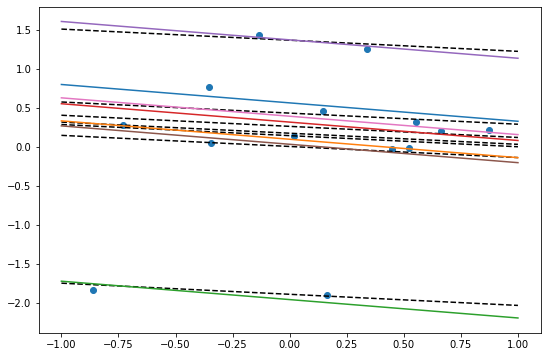

In [10]:
x_grid = jnp.broadcast_to(jnp.linspace(-1, 1, num=3)[None, :], shape=(n_regressions, 3))
f_grid = f(x_grid, w_true, b_true)
p_grid = f(x_grid, w, b)

plt.figure(figsize=(9, 6))
plt.plot(x_grid.T, f_grid.T, color='black', linestyle='--')
plt.plot(x_grid.T, p_grid.T)
plt.scatter(data.ravel(), labels.ravel())
plt.show()